In [1]:
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss

from cfair.backends import NumpyBackend
from cfair.metrics.kernel.hgr import CategoricalHGR, DoubleKernelHGR

In [2]:
backend = NumpyBackend()

# Cramer's V

In [3]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# OHE kernel function

In [149]:
def one_hot_encode(x):
        unique_vals = np.unique(x)
        return np.array([[1 if val == xi else 0 for val in unique_vals] for xi in x]).transpose()

# Toy Class

In [5]:
toy_one_hot_hgr = CategoricalHGR(
    backend=backend,
    method='trust-constr',
    maxiter=1000,
    eps=1e-9,
    tol=1e-9,
    use_lstsq=True,
    delta_independent=None
)

## First Example - corr = 0

In [6]:
# Example categorical data
a = np.array(['cat', 'dog', 'cat', 'bird'])
b = np.array(['red', 'red', 'blue', 'green'])

In [7]:

ohe_a = one_hot_encode(a)
ohe_b = one_hot_encode(b)

In [8]:
print(ohe_a)

[[0 0 0 1]
 [1 0 1 0]
 [0 1 0 0]]


In [9]:
print(ohe_b)

[[0 0 1 0]
 [0 0 0 1]
 [1 1 0 0]]


In [10]:
result = toy_one_hot_hgr._compute(a, b)
print(result)

None


In [11]:
corr, alpha, beta = toy_one_hot_hgr._indicator(ohe_a, ohe_b, None, None)
print(corr, alpha, beta)

0.9449111800932964 [0.19385645 0.54457232 0.19385645 0.30321213] [0.22038587 0.22038587 0.24541706 0.3138112 ]


## Second Example - corr = 0

In [12]:
c = np.array(['cat', 'dog', 'cat', 'bird'])
d = np.array(['cat', 'dog', 'cat', 'bird'])

In [13]:
ohe_c = one_hot_encode(c)
ohe_d = one_hot_encode(d)

In [14]:
print(ohe_c)

[[0 0 0 1]
 [1 0 1 0]
 [0 1 0 0]]


In [15]:
print(ohe_d)

[[0 0 0 1]
 [1 0 1 0]
 [0 1 0 0]]


In [16]:
result = toy_one_hot_hgr._compute(c, d)
print(result)

None


In [17]:
corr, alpha, beta = toy_one_hot_hgr._indicator(ohe_c, ohe_d, None, None)
print(corr, alpha, beta)

0.999999998875 [0.26516504 0.26516504 0.26516504 0.26516504] [0.25 0.25 0.25 0.25]


# Polinomial Kernels test

In [18]:
polynomial_kernel = DoubleKernelHGR(
    backend=backend,          
    kernel_a=2, 
    kernel_b=3, 
)

## Joke Experiment

In [19]:
a = np.array([1, 2, 3, 4, 5])
b = np.array([5, 4, 3, 2, 1])

result_p = polynomial_kernel._compute(a, b)

In [20]:
print(result_p.value)

0.9999999989999997


In [21]:
print(result_p.alpha)

[-0.98971955 -0.01028045]


In [22]:
print(result_p.beta)

[ 9.90848562e-01 -9.15143279e-03 -5.25302806e-09]


## 50000, all random

In [23]:
num1 = []
num2 = []

for i in range(50000):
    num1.append(rn.randint(0,9))
    num2.append(rn.randint(0,9))

In [24]:
result_50000_pol = polynomial_kernel._compute(num1, num2)

In [25]:
print(result_50000_pol.value)

0.002260964800911911


In [26]:
print(result_50000_pol.alpha)

[ 0.95591086 -0.04408914]


In [27]:
print(result_50000_pol.beta)

[ 0.79060664 -0.14080855  0.0685848 ]


# Instantiating my class

In [28]:
my_kernel_one_hot = DoubleKernelHGR(
    backend=backend,          # Or any other appropriate backend
    kernel_a=one_hot_encode, # Custom kernel function for variable a
    kernel_b=one_hot_encode, # Custom kernel function for variable b
)

## Experiment 1 (numbers)

In [29]:
a = np.array([1, 2, 3, 4, 5])
b = np.array([5, 4, 2, 2, 1])

# Compute the HGR indicator
result1 = my_kernel_one_hot._compute(a, b)

In [30]:
print(result1.value)

0.9999999990000001


In [31]:
print(result1.alpha)

[0.20000184 0.20000837 0.20000051 0.20000051 0.19998878]


In [32]:
print(result1.beta)

[0.24998613 0.25000079 0.25001062 0.25000246]


## Experiment 2 (categorical)

In [33]:
a2 = np.array(['cat', 'dog', 'cat', 'dog'])
b2 = np.array(['sus', 'sis', 'sus', 'ses'])

result2 = my_kernel_one_hot._compute(a2, b2)

In [34]:
print(result2.value)

0.9999999989999999


In [35]:
print(result2.a)

['cat' 'dog' 'cat' 'dog']


In [36]:
print(result2.b)

['sus' 'sis' 'sus' 'ses']


In [37]:
print(result2.alpha)

[0.49998419 0.50001581]


In [38]:
print(result2.beta)

[0.33334036 0.33334036 0.33331928]


## DEBUG CONCATENATION

In [39]:
f = [ [1, 0],[0, 1],[1, 0],[1, 0] ]

f = np.stack(f, axis=1)
f = f - np.mean(f, axis=0)

print(f)

# g = np.stack(g, axis=1)
# g = g - np.mean(g, axis=0)

# print(g)

[[ 0.5 -0.5  0.5  0.5]
 [-0.5  0.5 -0.5 -0.5]]


# Warriors/Animals experiments

## 1. All Random

In [40]:
warriors = ["Ultramarine", "Salamander", "White Scar", "Space Wolf", "Raven Guard", "Iron Hand", "Imperial Fist", "Blood Angel", "Dark Angel"]
animals = ["cat", "dog", "monke", "horse"]

def sample(a_list):
    return rn.choice(a_list)

ani = []
war = []

for i in range(50000):
    ani.append(sample(animals))
    war.append(sample(warriors))

In [41]:
print(ani)

['dog', 'horse', 'horse', 'dog', 'monke', 'cat', 'cat', 'monke', 'horse', 'cat', 'cat', 'dog', 'monke', 'monke', 'horse', 'horse', 'cat', 'dog', 'horse', 'dog', 'cat', 'monke', 'monke', 'dog', 'horse', 'monke', 'dog', 'horse', 'dog', 'horse', 'monke', 'dog', 'cat', 'horse', 'cat', 'cat', 'monke', 'dog', 'monke', 'monke', 'monke', 'dog', 'monke', 'horse', 'monke', 'horse', 'horse', 'cat', 'horse', 'cat', 'dog', 'dog', 'cat', 'monke', 'cat', 'cat', 'dog', 'horse', 'dog', 'dog', 'cat', 'monke', 'cat', 'dog', 'monke', 'cat', 'cat', 'dog', 'monke', 'horse', 'dog', 'monke', 'monke', 'dog', 'dog', 'dog', 'dog', 'cat', 'horse', 'dog', 'horse', 'horse', 'dog', 'dog', 'dog', 'dog', 'monke', 'cat', 'monke', 'horse', 'monke', 'cat', 'horse', 'cat', 'dog', 'horse', 'cat', 'horse', 'dog', 'horse', 'horse', 'dog', 'monke', 'horse', 'cat', 'horse', 'monke', 'dog', 'dog', 'dog', 'horse', 'monke', 'cat', 'horse', 'horse', 'horse', 'cat', 'dog', 'horse', 'dog', 'horse', 'horse', 'monke', 'dog', 'monke', 

In [42]:
print(war)

['Salamander', 'Imperial Fist', 'Ultramarine', 'White Scar', 'White Scar', 'Salamander', 'Salamander', 'Dark Angel', 'Iron Hand', 'Raven Guard', 'Raven Guard', 'Raven Guard', 'Dark Angel', 'Ultramarine', 'Raven Guard', 'Raven Guard', 'Salamander', 'Dark Angel', 'Dark Angel', 'Space Wolf', 'Space Wolf', 'Imperial Fist', 'Iron Hand', 'Dark Angel', 'Salamander', 'Space Wolf', 'Blood Angel', 'Salamander', 'Space Wolf', 'Space Wolf', 'Raven Guard', 'White Scar', 'Imperial Fist', 'Imperial Fist', 'Iron Hand', 'Salamander', 'Dark Angel', 'Dark Angel', 'Blood Angel', 'Dark Angel', 'White Scar', 'Iron Hand', 'Blood Angel', 'Imperial Fist', 'Raven Guard', 'Iron Hand', 'Ultramarine', 'Space Wolf', 'Iron Hand', 'Space Wolf', 'Iron Hand', 'Raven Guard', 'Raven Guard', 'Dark Angel', 'Ultramarine', 'Space Wolf', 'Iron Hand', 'Raven Guard', 'Space Wolf', 'Salamander', 'Salamander', 'Imperial Fist', 'Dark Angel', 'Raven Guard', 'Imperial Fist', 'Raven Guard', 'Raven Guard', 'Salamander', 'Raven Guard',

In [43]:
result_ar = my_kernel_one_hot._result(war, ani, kernel_a=True, kernel_b=True, a0=np.ones(9), b0=np.ones(4))#_compute(war, ani)

In [44]:
print(result_ar.value)

0.013613552447582614


In [45]:
print(result_ar.alpha)

[0.11206849 0.10973471 0.11275289 0.10968879 0.11342375 0.11267968
 0.10924163 0.11042605 0.109984  ]


In [46]:
print(result_ar.beta)

[ 0.19601155 -0.01112678  0.47907396  0.31378771]


### Confusion Matrix extravaganza All Random

In [47]:
legionAllRand = pd.DataFrame({'warrior': war, 'steed': ani})

In [48]:
legionAllRand

,warrior,steed
0,Salamander,dog
1,Imperial Fist,horse
2,Ultramarine,horse
3,White Scar,dog
4,White Scar,monke
...,...,...
49995,Imperial Fist,dog
49996,Blood Angel,horse
49997,Dark Angel,cat
49998,Space Wolf,cat


In [49]:
confusion_matrix = pd.crosstab(legionAllRand['warrior'], legionAllRand['steed'])
print(confusion_matrix)

steed           cat   dog  horse  monke
warrior                                
Blood Angel    1387  1375   1420   1403
Dark Angel     1443  1389   1369   1365
Imperial Fist  1396  1315   1378   1415
Iron Hand      1411  1406   1381   1359
Raven Guard    1384  1360   1443   1446
Salamander     1405  1362   1428   1421
Space Wolf     1363  1389   1324   1401
Ultramarine    1343  1440   1421   1396
White Scar     1381  1380   1365   1336


In [50]:
cramers_v(confusion_matrix.values)

0.0

## 2. Autocorrelation

In [51]:
result_auto = my_kernel_one_hot._result(war, war, kernel_a=True, kernel_b=True, a0=np.ones(9), b0=np.ones(9))#_compute(war, war)

In [52]:
print(result_auto.value)

0.9999999990002355


In [53]:
print(result_auto.alpha)

[-0.07364355  0.21069825  0.01205154  0.1168567   0.02128839  0.09751088
  0.06249416  0.23172652  0.17373001]


In [54]:
print(result_auto.beta)

[-0.07256075  0.21035895  0.01270575  0.11698674  0.0218964   0.09773767
  0.06289609  0.23128205  0.17357561]


It is VERY HIGH -> as i expected, VERY GOODDE!!

### Confusion Matrix extravaganza Autoc

In [55]:
legionAuto = pd.DataFrame({'warrior1': war, 'warrior2': war})

In [56]:
legionAuto

,warrior1,warrior2
0,Salamander,Salamander
1,Imperial Fist,Imperial Fist
2,Ultramarine,Ultramarine
3,White Scar,White Scar
4,White Scar,White Scar
...,...,...
49995,Imperial Fist,Imperial Fist
49996,Blood Angel,Blood Angel
49997,Dark Angel,Dark Angel
49998,Space Wolf,Space Wolf


In [57]:
confusion_matrix = pd.crosstab(legionAuto['warrior1'], legionAuto['warrior2'])
print(confusion_matrix)

warrior2       Blood Angel  Dark Angel  Imperial Fist  Iron Hand  Raven Guard  \
warrior1                                                                        
Blood Angel           5585           0              0          0            0   
Dark Angel               0        5566              0          0            0   
Imperial Fist            0           0           5504          0            0   
Iron Hand                0           0              0       5557            0   
Raven Guard              0           0              0          0         5633   
Salamander               0           0              0          0            0   
Space Wolf               0           0              0          0            0   
Ultramarine              0           0              0          0            0   
White Scar               0           0              0          0            0   

warrior2       Salamander  Space Wolf  Ultramarine  White Scar  
warrior1                                   

In [58]:
cramers_v(confusion_matrix.values)

1.0

## 3. "Via di mezzo"

In [59]:
ani2 = []

for warrior in war:
    if warrior == "White Scar":
        anim = "horse"
    else:
        anim = sample(animals)
    ani2.append(anim)

In [60]:
print(ani2)

['monke', 'monke', 'cat', 'horse', 'horse', 'cat', 'horse', 'horse', 'dog', 'cat', 'horse', 'horse', 'horse', 'monke', 'cat', 'monke', 'cat', 'dog', 'monke', 'cat', 'dog', 'cat', 'horse', 'horse', 'cat', 'horse', 'horse', 'cat', 'cat', 'dog', 'monke', 'horse', 'monke', 'dog', 'horse', 'monke', 'horse', 'cat', 'cat', 'horse', 'horse', 'horse', 'horse', 'monke', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'horse', 'horse', 'horse', 'monke', 'horse', 'cat', 'dog', 'horse', 'monke', 'dog', 'cat', 'monke', 'monke', 'monke', 'dog', 'horse', 'cat', 'monke', 'monke', 'monke', 'horse', 'monke', 'horse', 'cat', 'cat', 'monke', 'horse', 'horse', 'cat', 'horse', 'monke', 'monke', 'dog', 'monke', 'horse', 'cat', 'cat', 'cat', 'horse', 'monke', 'dog', 'cat', 'horse', 'dog', 'horse', 'horse', 'dog', 'horse', 'dog', 'horse', 'cat', 'monke', 'dog', 'monke', 'horse', 'horse', 'dog', 'dog', 'dog', 'monke', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'monke', 'monke', 'monke', 'horse', 'dog', 'horse', 

### Old way (legacy): using the _compute method

AS we can see, if we use it the betas do not change at all.

In [61]:
result_vdm = my_kernel_one_hot._compute(war, ani2)

In [62]:
print(result_vdm.value)

0.24025311210619169


In [63]:
print(result_vdm.alpha)

[0.11111085 0.11111085 0.11111085 0.11111087 0.11111081 0.11111078
 0.11111087 0.11111084 0.1111133 ]


In [64]:
print(result_vdm.beta)

[0.25000464 0.24998601 0.25000609 0.25000326]


## Calling directly "_result" [very important experiment, discovered a LOT of things]

If we do not initialize a0 and b0, they will NOT change. BUT, if we initialize them to be all ones, well they will indeed change and at the end their value will highlight the most correlated categories. This is awesome!!

In [65]:
result_vdm = my_kernel_one_hot._result(war, ani2, kernel_a=True, kernel_b=True, a0=np.ones(9), b0=np.ones(4))

In [66]:
print(result_vdm.value)

0.23979844183651328


In [67]:
print(result_vdm.alpha)

[0.10275172 0.10282302 0.10282742 0.10342068 0.1014887  0.10071062
 0.10343275 0.10247222 0.18007285]


In [68]:
print(np.unique(result_vdm.a))

['Blood Angel' 'Dark Angel' 'Imperial Fist' 'Iron Hand' 'Raven Guard'
 'Salamander' 'Space Wolf' 'Ultramarine' 'White Scar']


As we can see, the highest (or lowest) alfa is the one relative to the 'White Scar', that is the warrior that always chooses the 'horse'! (the more "correlated")

In [69]:
print(result_vdm.beta)

[ 0.31058295 -0.06715616  0.33957164  0.28268925]


In [70]:
print(np.unique(result_vdm.b))

['cat' 'dog' 'horse' 'monke']


As we can see, the highest (or lowest) beta is the one relative to the 'horse', that is the steed that's always choosen by the 'White Scar'! (the more "correlated")

### Confusion Matrix extravaganza W

In [71]:
legionW = pd.DataFrame({'warrior': war, 'steed': ani2})

In [72]:
legionW

,warrior,steed
0,Salamander,monke
1,Imperial Fist,monke
2,Ultramarine,cat
3,White Scar,horse
4,White Scar,horse
...,...,...
49995,Imperial Fist,cat
49996,Blood Angel,cat
49997,Dark Angel,horse
49998,Space Wolf,monke


In [73]:
confusion_matrix = pd.crosstab(legionW['warrior'], legionW['steed'])
print(confusion_matrix)

steed           cat   dog  horse  monke
warrior                                
Blood Angel    1380  1385   1370   1450
Dark Angel     1405  1380   1355   1426
Imperial Fist  1391  1364   1332   1417
Iron Hand      1370  1370   1428   1389
Raven Guard    1359  1429   1441   1404
Salamander     1378  1439   1390   1409
Space Wolf     1412  1351   1369   1345
Ultramarine    1374  1397   1400   1429
White Scar        0     0   5462      0


In [74]:
cramers_v(confusion_matrix.values)

0.28737981910308047

## White Scar - horse and Raven Guard - cat

In [75]:
ani3 = []

for warrior in war:
    if warrior == "White Scar":
        anim = "horse"
    elif warrior == "Raven Guard":
        anim="cat"
    else:
        anim = sample(animals)
    ani3.append(anim)

In [76]:
result_vdmwr = my_kernel_one_hot._result(war, ani3, kernel_a=True, kernel_b=True, a0=np.ones(9), b0=np.ones(4))

In [77]:
print(result_vdmwr.value)

0.511881022999442


(0.6216869820138966 with a0 and b0 None)

In [78]:
print(result_vdmwr.alpha)

[0.09152759 0.09380483 0.09020721 0.0911064  0.08809087 0.09096701
 0.09296569 0.09117823 0.27015218]


In [79]:
print(np.unique(result_vdmwr.a))

['Blood Angel' 'Dark Angel' 'Imperial Fist' 'Iron Hand' 'Raven Guard'
 'Salamander' 'Space Wolf' 'Ultramarine' 'White Scar']


The 'White Scar' has a big value, as we should expect, and the other "anomalous" value is the 'Raven Guard', that is around 0 (or viceversa). They are indeed the two 'correlated' warriors!!

In [80]:
print(result_vdmwr.beta)

[ 0.18426634 -0.01292723  0.78139111 -0.02141532]


In [81]:
print(np.unique(result_vdmwr.b))

['cat' 'dog' 'horse' 'monke']


Here 'cat' and 'horse' are the anomalous values. Why cat (or horse) is negative?

In [82]:
print(war.count('Raven Guard'))
print(war.count('White Scar'))
print(war.count('Iron Hand'))

5633
5462
5557


### Confusion Matrix extravaganza WR

In [83]:
legionWR = pd.DataFrame({'warrior': war, 'steed': ani3})

In [84]:
legionWR

,warrior,steed
0,Salamander,monke
1,Imperial Fist,dog
2,Ultramarine,cat
3,White Scar,horse
4,White Scar,horse
...,...,...
49995,Imperial Fist,horse
49996,Blood Angel,monke
49997,Dark Angel,cat
49998,Space Wolf,monke


In [85]:
confusion_matrix = pd.crosstab(legionWR['warrior'], legionWR['steed'])
print(confusion_matrix)

steed           cat   dog  horse  monke
warrior                                
Blood Angel    1415  1390   1402   1378
Dark Angel     1431  1355   1438   1342
Imperial Fist  1309  1397   1382   1416
Iron Hand      1344  1379   1407   1427
Raven Guard    5633     0      0      0
Salamander     1436  1383   1394   1403
Space Wolf     1387  1317   1405   1368
Ultramarine    1372  1443   1413   1372
White Scar        0     0   5462      0


In [86]:
cramers_v(confusion_matrix.values)

0.4252558087314686

# 0. Proviamo 30 run diverse - INIZIALIZZANDO a0 e b0 VS non inizializzando

In [87]:
results = []

for i in range(30):

    ani_i = []
    war_i = []
    res_i = {}

    for i in range(50000):
        
        warrior=sample(warriors)

        war_i.append(warrior)

        if warrior == "White Scar":
            anim = "horse"
        elif warrior == "Raven Guard":
            anim="cat"
        else:
            anim = sample(animals)

        ani_i.append(anim)

    result_i = my_kernel_one_hot._result(war_i, ani_i, kernel_a=True, kernel_b=True, a0=np.ones(9), b0=np.ones(4))

    result_i_none = my_kernel_one_hot._result(war_i, ani_i, kernel_a=True, kernel_b=True, a0=None, b0=None)

    confusion_matrix = pd.crosstab(war_i, ani_i)

    res_i['correlation'] = result_i.value
    res_i['alpha'] = result_i.alpha
    res_i['beta'] = result_i.beta

    res_i['correlation_none'] = result_i_none.value
    res_i['alpha_none'] = result_i_none.alpha
    res_i['beta_none'] = result_i_none.beta

    res_i['cramers_v'] = cramers_v(confusion_matrix.values)

    results.append(res_i)

## Plot correlations 

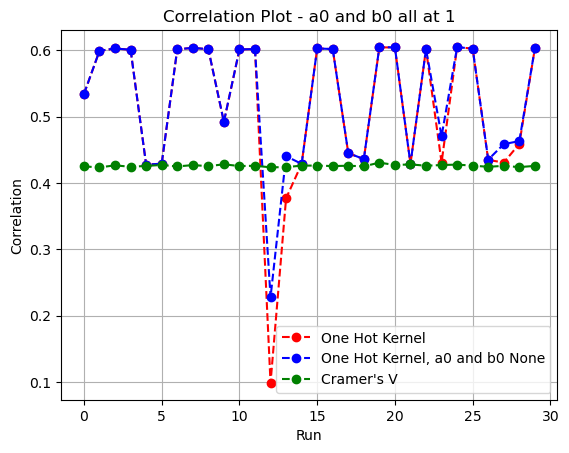

In [88]:
correlations = [res['correlation'] for res in results]
correlations_none = [res['correlation_none'] for res in results]
cramers = [res['cramers_v'] for res in results]

plt.plot(correlations, marker='o', linestyle='--', color='r', label='One Hot Kernel')
plt.plot(correlations_none, marker='o', linestyle='--', color='b', label='One Hot Kernel, a0 and b0 None')
plt.plot(cramers, marker='o', linestyle='--', color='g', label='Cramer\'s V')
plt.title('Correlation Plot - a0 and b0 all at 1')
plt.xlabel('Run')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()

Beh, la maggior parte delle volte è coerente, ma a volte wiggela. Forse il problema è dovuto al fatto che l'ultima colonna è SEMPRE linearmente dipendente alle altre.

In [89]:
print(np.unique(result_vdmwr.a))

['Blood Angel' 'Dark Angel' 'Imperial Fist' 'Iron Hand' 'Raven Guard'
 'Salamander' 'Space Wolf' 'Ultramarine' 'White Scar']


In [90]:
print(np.unique(result_vdmwr.b))

['cat' 'dog' 'horse' 'monke']


## Plot Betas vs Beta none

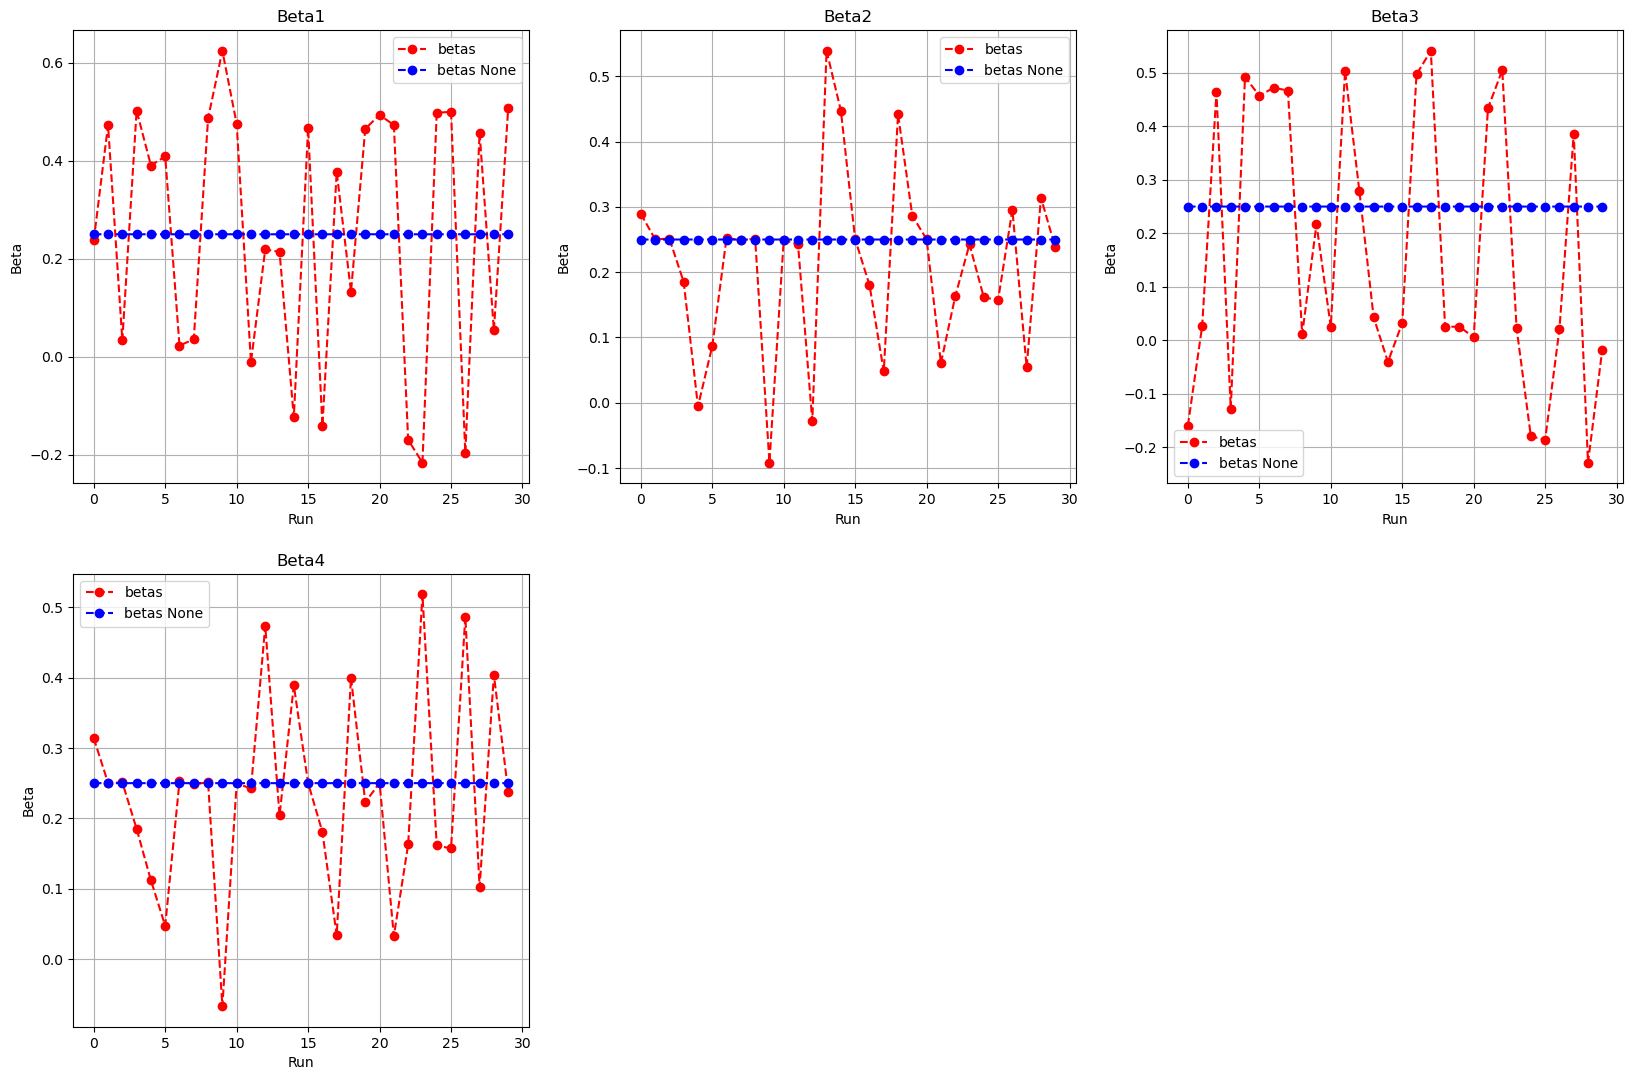

In [91]:
plt.figure(figsize=(20, 20))

for i in range(4):

    betas = [res['beta'][i] for res in results]
    betas_none = [res['beta_none'][i] for res in results]

    plt.subplot(3, 3, i+1)

    plt.plot(betas, marker='o', linestyle='--', color='r', label='betas')
    plt.plot(betas_none, marker='o', linestyle='--', color='b', label='betas None')

    plt.title('Beta' + str(i+1))
    plt.xlabel('Run')
    plt.ylabel('Beta')
    plt.legend()
    plt.grid(True)

plt.show()

Quelle che wiggelano di più sono la prima e la terza, horse and cat. Come mi aspettavo!

## Plot Alpha vs Alpha none

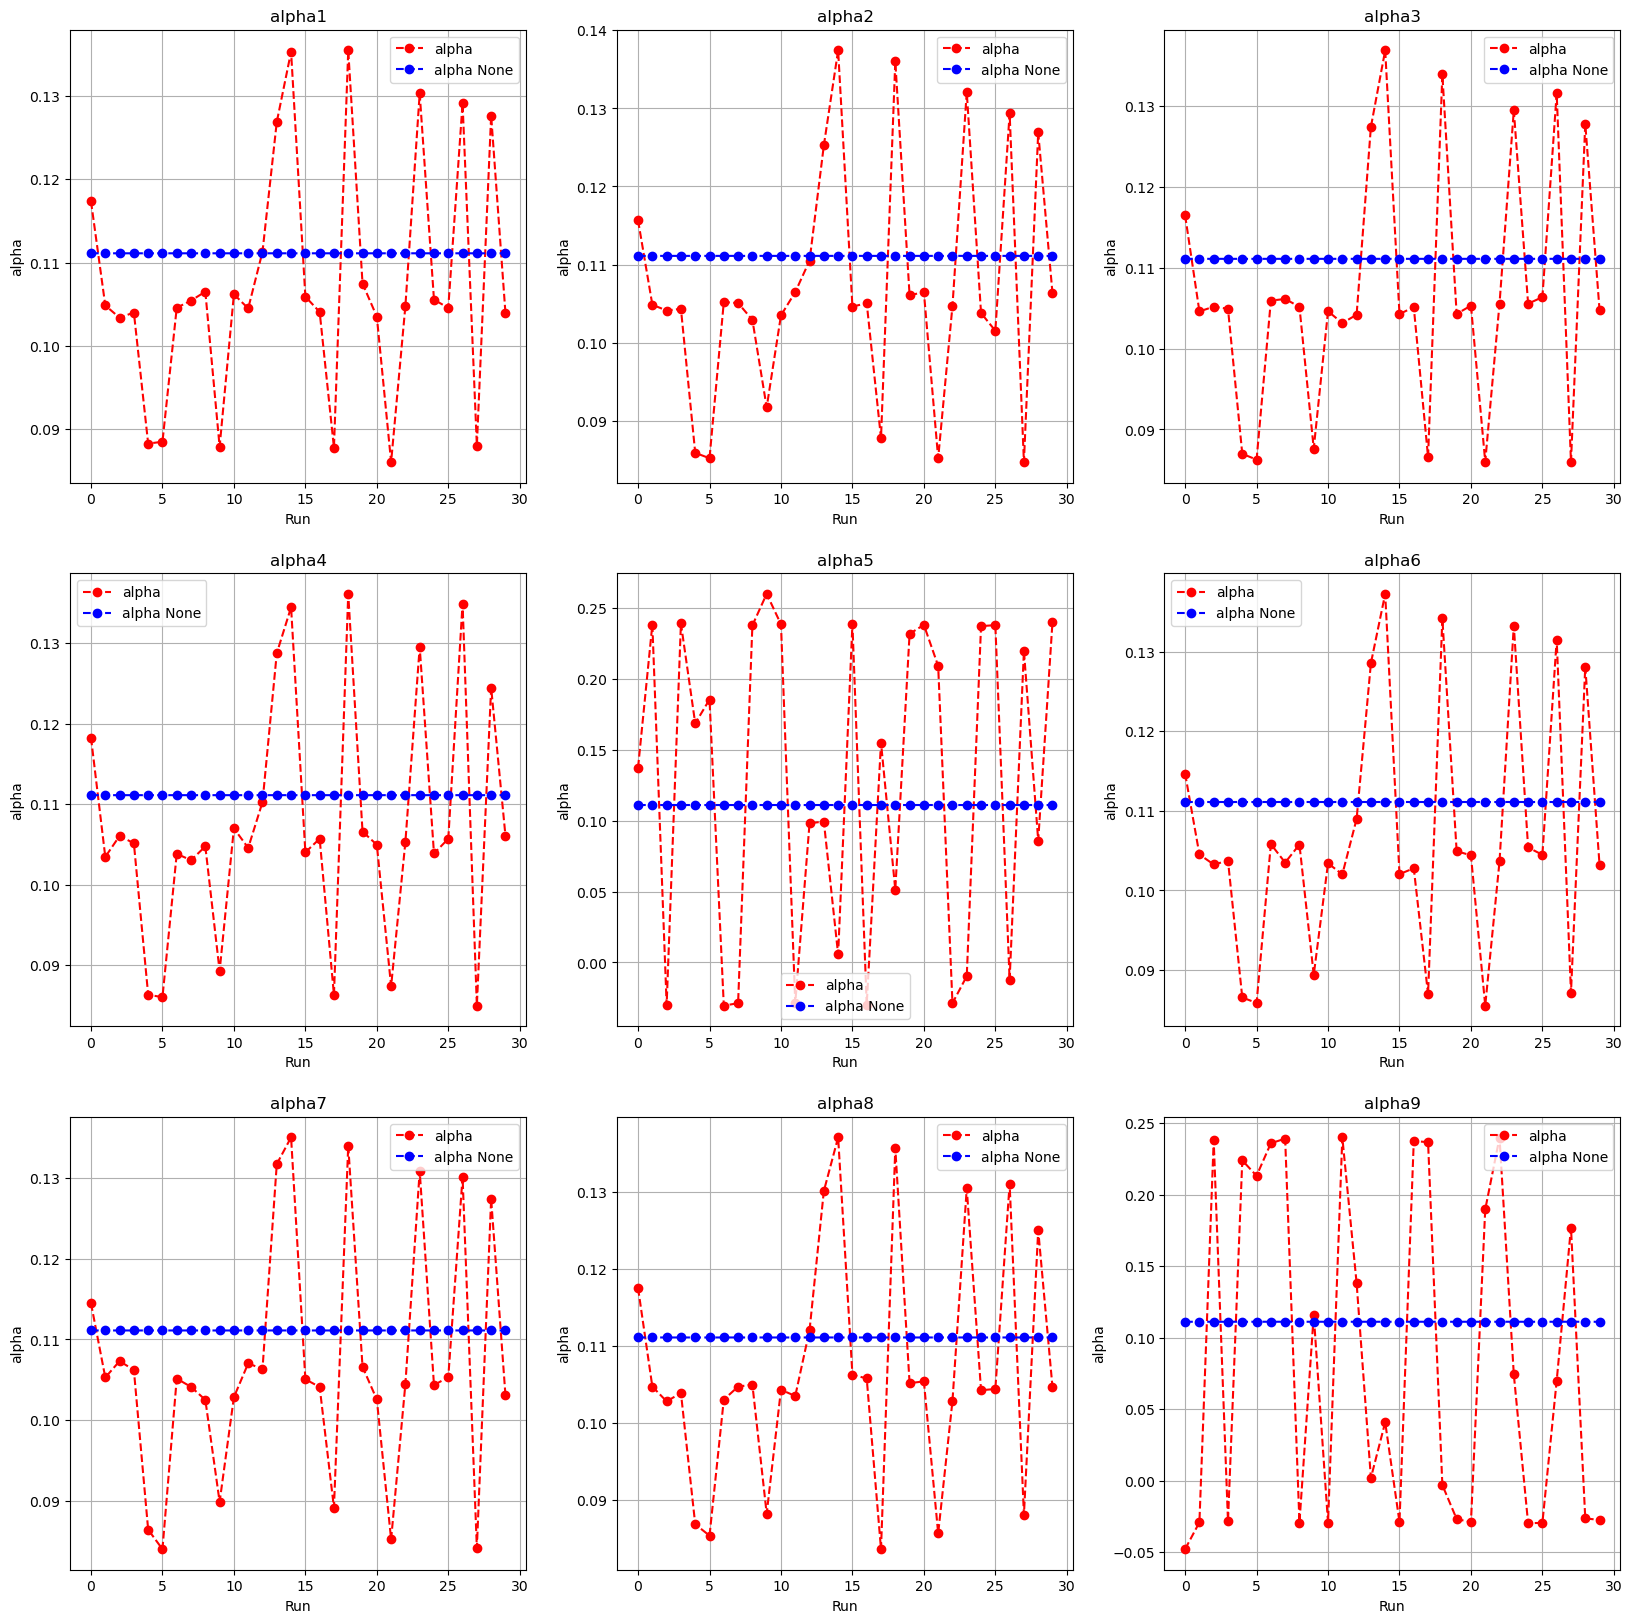

In [93]:
plt.figure(figsize=(20, 20))

for i in range(9):

    alpha = [res['alpha'][i] for res in results]
    alpha_none = [res['alpha_none'][i] for res in results]

    plt.subplot(3, 3, i+1)

    plt.plot(alpha, marker='o', linestyle='--', color='r', label='alpha')
    plt.plot(alpha_none, marker='o', linestyle='--', color='b', label='alpha None')

    plt.title('alpha' + str(i+1))
    plt.xlabel('Run')
    plt.ylabel('alpha')
    plt.legend()
    plt.grid(True)

plt.show()

Quelle che wiggelano di più sono la quinta e la nona, Raven Guard and White Scar. Come mi aspettavo!

# 1. Proviamo 30 run diverse - mettiamo il delta per rimuovere le colonne linearmente dipendenti

In [154]:
my_kernel_one_hot_with_delta = DoubleKernelHGR(
    backend=backend,          # Or any other appropriate backend
    kernel_a=one_hot_encode, # Custom kernel function for variable a
    kernel_b=one_hot_encode, # Custom kernel function for variable b
    delta_independent=0.2
)

In [155]:
results = []

for i in range(30):

    ani_i = []
    war_i = []
    res_i = {}

    for i in range(50000):
        
        warrior=sample(warriors)

        war_i.append(warrior)

        if warrior == "Ultramarine":
            anim = "horse"
        elif warrior == "Raven Guard":
            anim="cat"
        else:
            anim = sample(animals)

        ani_i.append(anim)

    result_i = my_kernel_one_hot_with_delta._result(war_i, ani_i, kernel_a=True, kernel_b=True, a0=np.ones(9), b0=np.ones(4))

    result_i_none = my_kernel_one_hot_with_delta._result(war_i, ani_i, kernel_a=True, kernel_b=True, a0=None, b0=None)

    confusion_matrix = pd.crosstab(war_i, ani_i)

    res_i['correlation'] = result_i.value
    res_i['alpha'] = result_i.alpha
    res_i['beta'] = result_i.beta

    res_i['correlation_none'] = result_i_none.value
    res_i['alpha_none'] = result_i_none.alpha
    res_i['beta_none'] = result_i_none.beta

    res_i['cramers_v'] = cramers_v(confusion_matrix.values)

    results.append(res_i)

## Plot correlations 

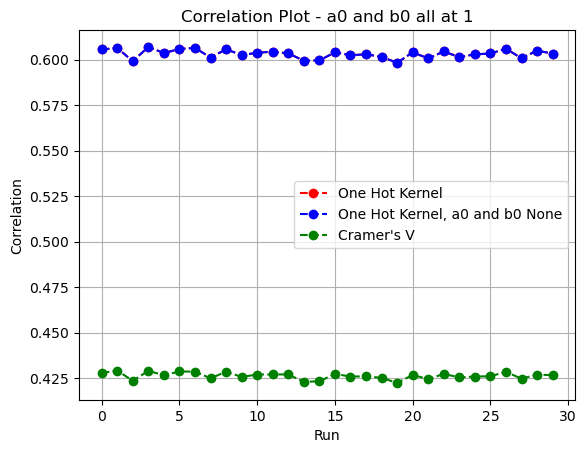

In [156]:
correlations = [res['correlation'] for res in results]
correlations_none = [res['correlation_none'] for res in results]
cramers = [res['cramers_v'] for res in results]

plt.plot(correlations, marker='o', linestyle='--', color='r', label='One Hot Kernel')
plt.plot(correlations_none, marker='o', linestyle='--', color='b', label='One Hot Kernel, a0 and b0 None')
plt.plot(cramers, marker='o', linestyle='--', color='g', label='Cramer\'s V')
plt.title('Correlation Plot - a0 and b0 all at 1')
plt.xlabel('Run')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()

WOW, il delta_independent ha svoltato la serata, ora la correlation calcolata è MOLTO più stabile!!

## Plot Betas vs Beta none

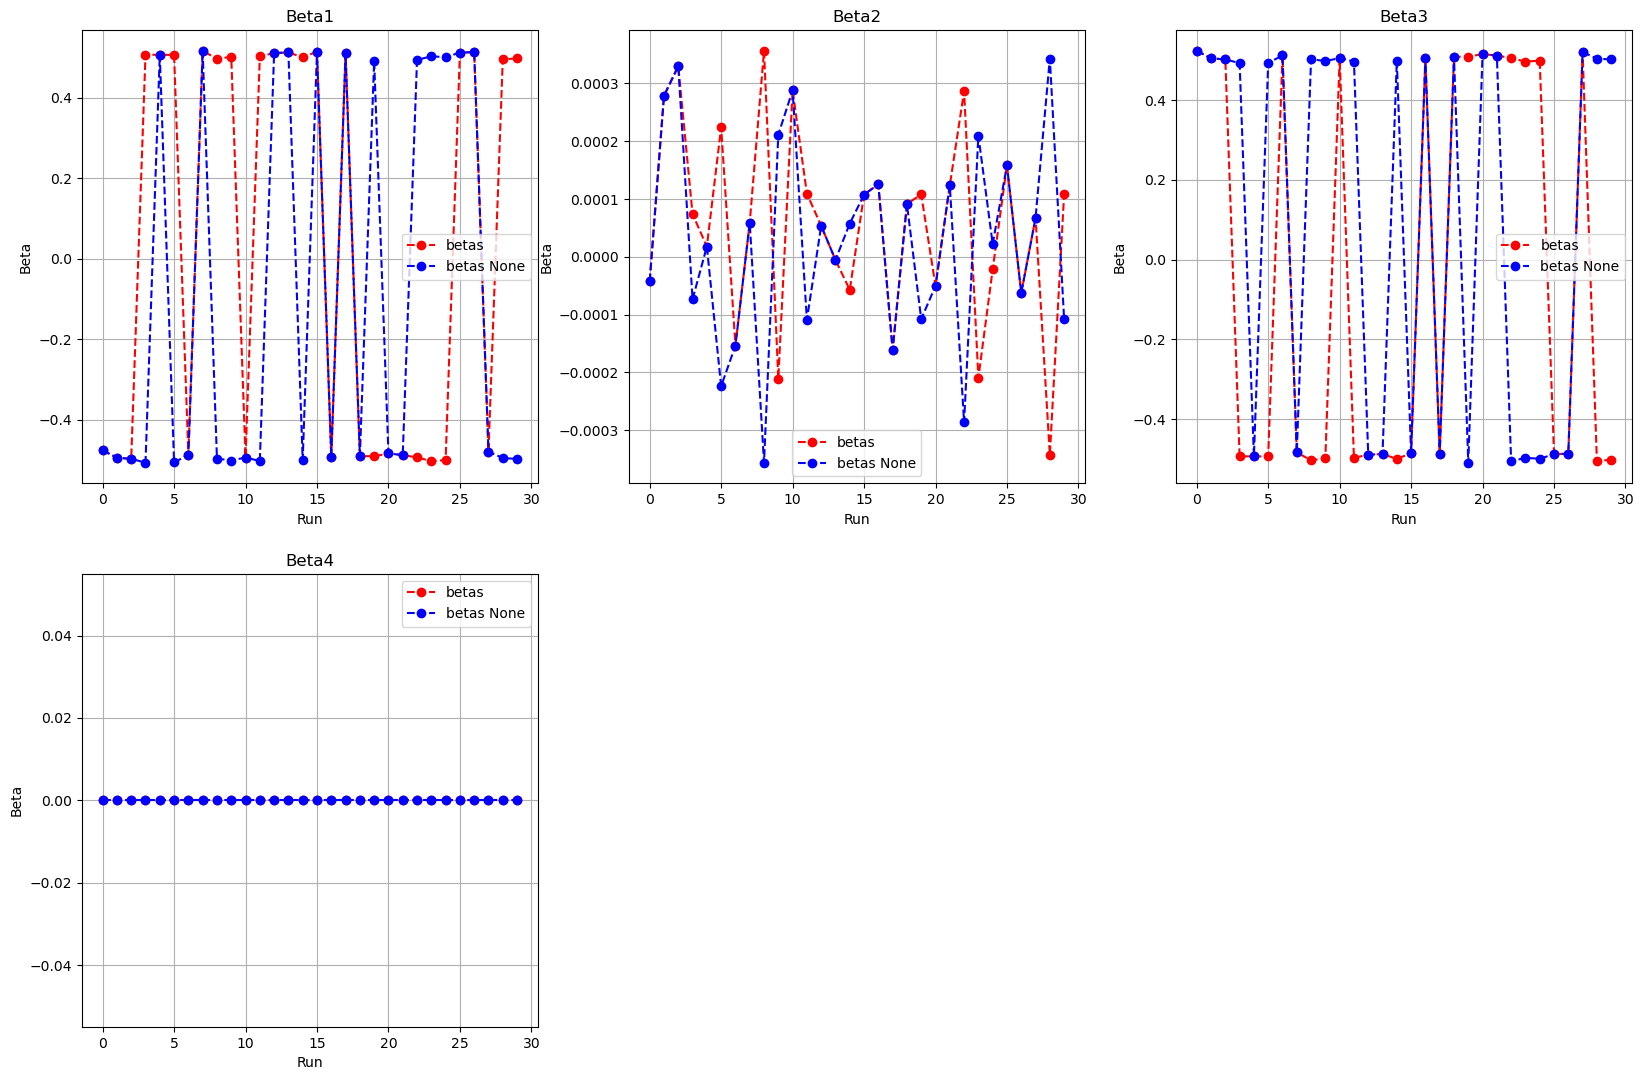

In [157]:
plt.figure(figsize=(20, 20))

for i in range(4):

    betas = [res['beta'][i] for res in results]
    betas_none = [res['beta_none'][i] for res in results]

    plt.subplot(3, 3, i+1)

    plt.plot(betas, marker='o', linestyle='--', color='r', label='betas')
    plt.plot(betas_none, marker='o', linestyle='--', color='b', label='betas None')

    plt.title('Beta' + str(i+1))
    plt.xlabel('Run')
    plt.ylabel('Beta')
    plt.legend()
    plt.grid(True)

plt.show()

La prima e la terza, quelle più "correlate", sono le più lontane dallo 0. La seconda è sempre intorno a 0 e la quarta è sempre a zero dato che è dipendente dalle altre.

## Plot Alpha vs Alpha none

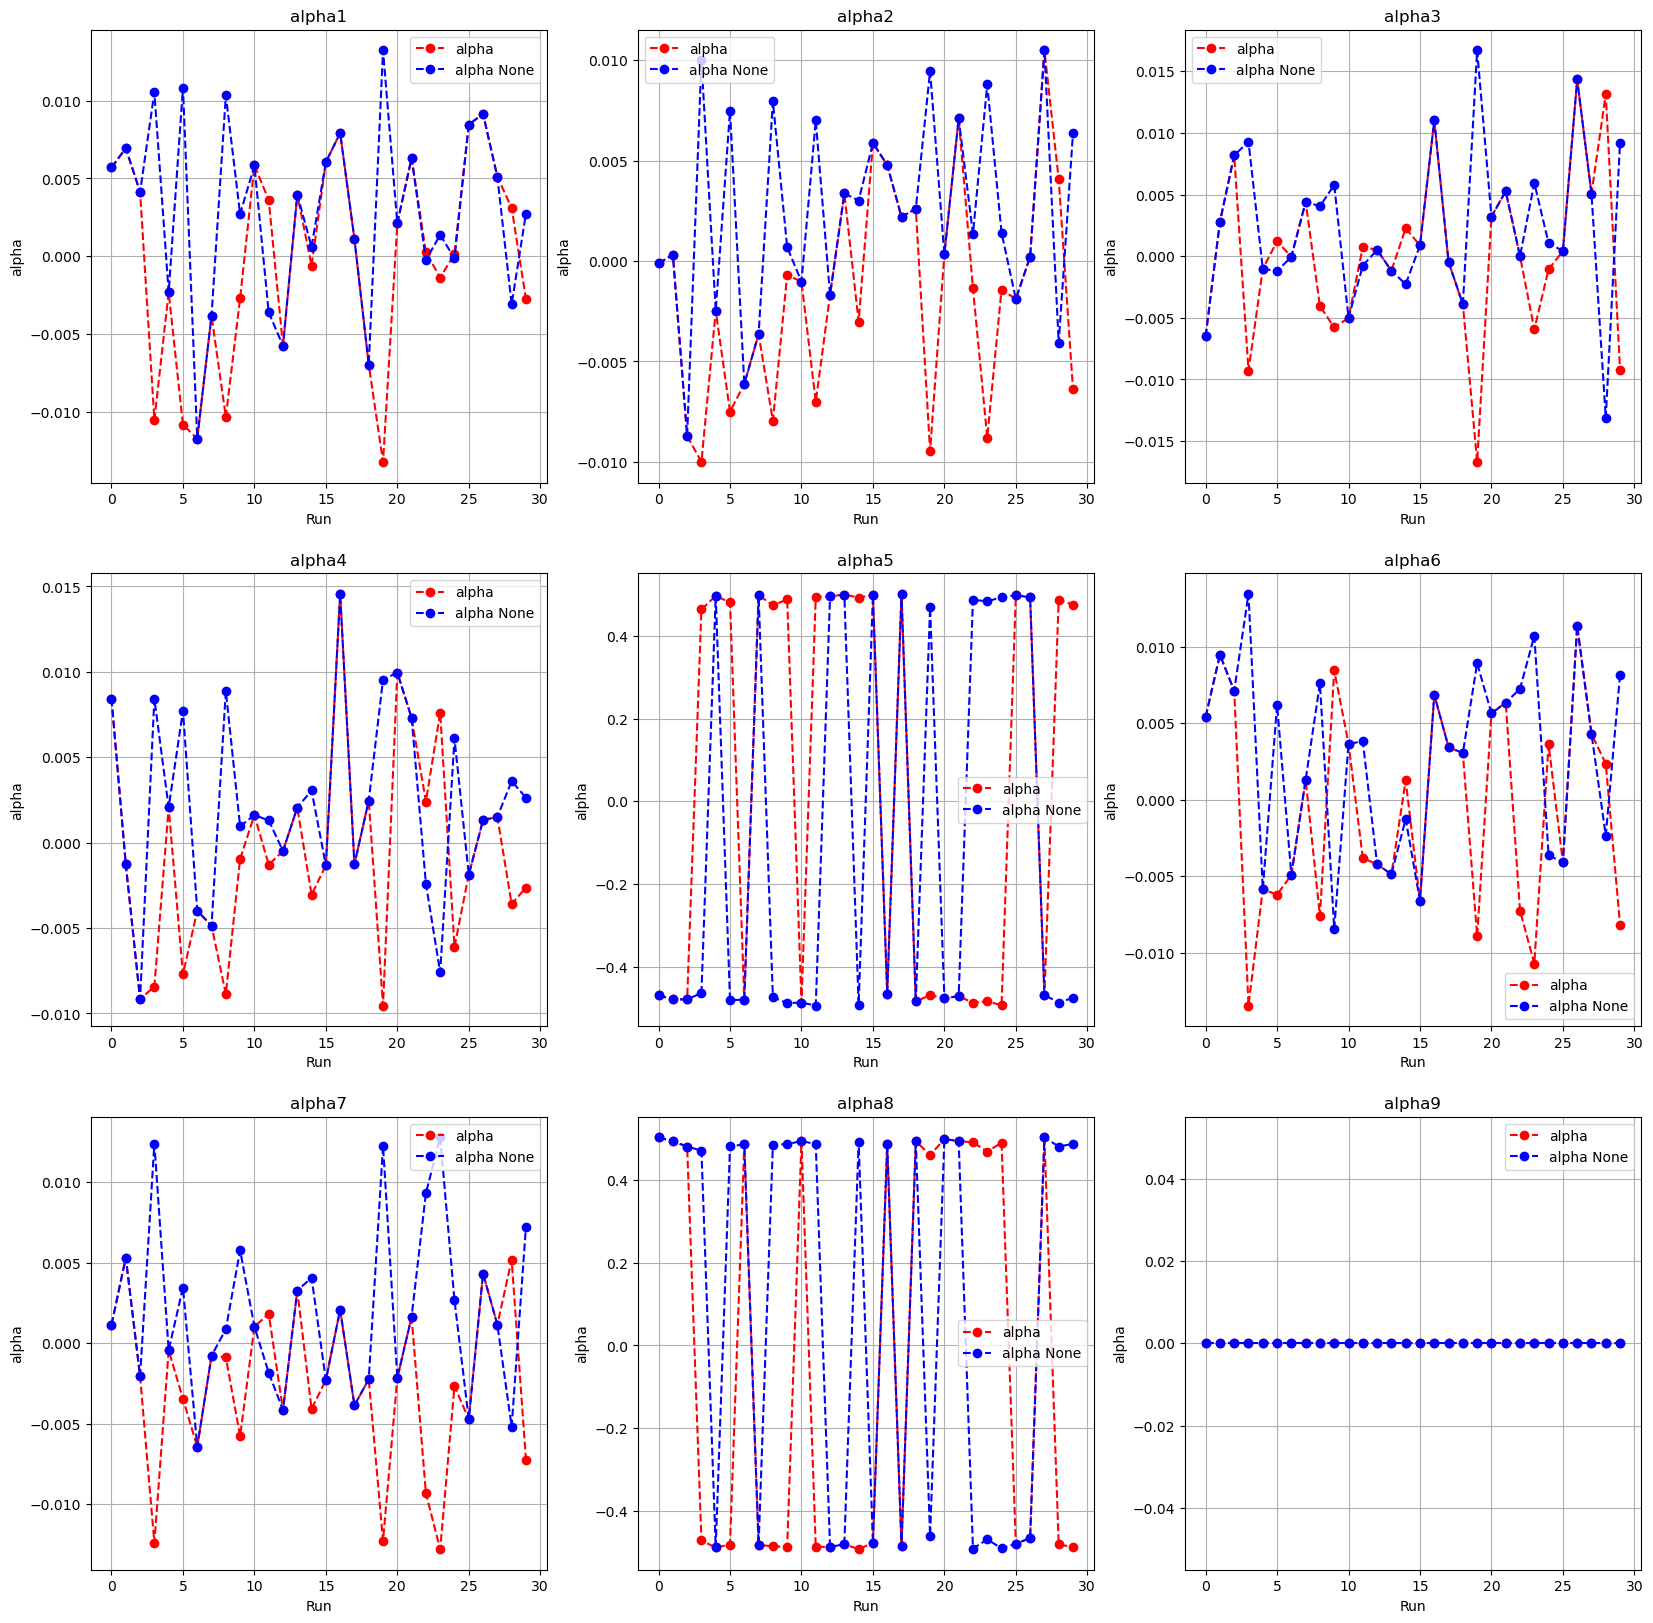

In [158]:
plt.figure(figsize=(20, 20))

for i in range(9):

    alpha = [res['alpha'][i] for res in results]
    alpha_none = [res['alpha_none'][i] for res in results]

    plt.subplot(3, 3, i+1)

    plt.plot(alpha, marker='o', linestyle='--', color='r', label='alpha')
    plt.plot(alpha_none, marker='o', linestyle='--', color='b', label='alpha None')

    plt.title('alpha' + str(i+1))
    plt.xlabel('Run')
    plt.ylabel('alpha')
    plt.legend()
    plt.grid(True)

plt.show()

La quinta, quella della Raven Guard, è sensibilmente più alta delle altre (il doppio), come ci aspettavamo!! Il problema è che l'ultima alpha, essendo l'ultima colonna linearmente dipendente dalle altre, è sempre a 0. In questo caso ciò è un problema dato che l'ultima colonna è relativa alla White Scar, che è correlata a horse e che quindi avrebbe molto probabilmente avuto un valore lontano da quello standard. Come risolvere il problema?

POSSIBILE SOLUZIONE: ????

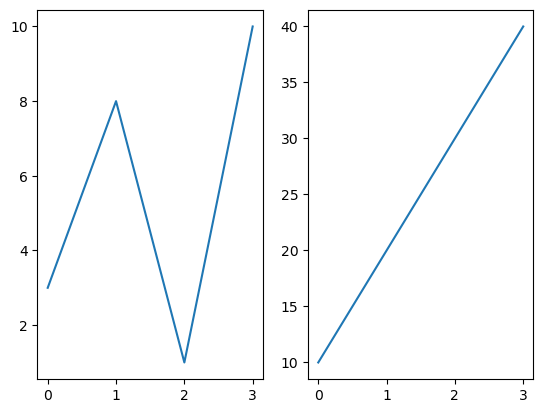

<Figure size 640x480 with 0 Axes>

In [147]:
x = np.array([0, 1, 2, 3])
y = np.array([3, 8, 1, 10])

plt.subplot(1, 2, 1)
plt.plot(x,y)

#plot 2:
x = np.array([0, 1, 2, 3])
y = np.array([10, 20, 30, 40])

plt.subplot(1, 2, 2)
plt.plot(x,y)

plt.show()
# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()